# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.627622,True,7.885050
1,-0.334633,False,-0.965668
2,0.550505,True,5.588215
3,-0.006640,True,4.198246
4,-1.623852,False,-3.253077
...,...,...,...
995,-0.002712,False,0.084613
996,0.675572,True,6.023857
997,0.776131,False,2.193610
998,0.286208,True,4.171823


<AxesSubplot:xlabel='v0'>

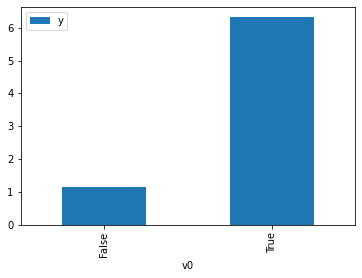

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

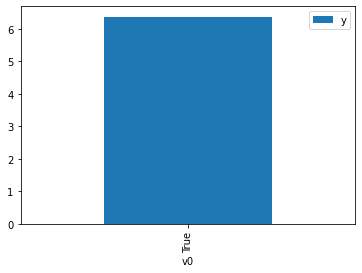

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.008104,False,0.226007,0.515897,1.938370
1,1.392089,False,2.505784,0.063560,15.733115
2,-0.377061,False,-1.473656,0.687665,1.454196
3,-1.030072,False,-1.772441,0.888299,1.125747
4,1.306722,False,2.138904,0.074316,13.456103
...,...,...,...,...,...
995,0.185086,False,-0.277756,0.421571,2.372079
996,0.156563,False,-1.130665,0.435307,2.297232
997,0.856506,False,2.438818,0.162903,6.138632
998,1.113007,False,1.102145,0.105153,9.509964


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.457884,True,8.845743,0.943720,1.059636
1,2.155559,True,11.465383,0.985103,1.015122
2,1.289358,True,7.711589,0.923301,1.083071
3,2.246441,True,7.854718,0.987511,1.012647
4,1.094905,True,5.851307,0.891450,1.121768
...,...,...,...,...,...
995,1.882233,True,5.346720,0.974767,1.025886
996,0.672204,True,4.895083,0.781482,1.279619
997,-0.851549,True,3.333244,0.151564,6.597871
998,0.638387,True,5.844696,0.769913,1.298848


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          1.814e+04
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        11:44:36   Log-Likelihood:                         -1415.2
No. Observations:                1000   AIC:                                      2834.
Df Residuals:                     998   BIC:                                      2844.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4639      0.038     38.169      0.000       1.389       1.539
x2             4.9882      0.059     84.107      0.000       4.872       5.105
==============================================================================
Omnibus:                        7.555   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                9.160
Skew:                           0.102   Prob(JB):                       0.0103
Kurtosis:                       3.422   Cond. No.                         3.28
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""